In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/sentiment-models')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#!pip uninstall pytorch-transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Load Dataset


In [ ]:
df_train = pd.read_csv("./input/train_2kmZucJ.csv")

In [ ]:
df_train

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...
...,...,...,...
7915,7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7916,7917,0,We would like to wish you an amazing day! Make...
7917,7918,0,Helping my lovely 90 year old neighbor with he...
7918,7919,0,Finally got my #smart #pocket #wifi stay conne...


In [ ]:
# Create sentence and label lists
sentences = df_train.tweet.values

We need to add special tokens ("[SEP]" and "[CLS]") at the beginning and end of each sentence for XLNet to work properly. 

For BERT, the special token pattern looks like this:

    [CLS] + Sentence_A + [SEP] + Sentence_B + [SEP]

Whereas with XLNet the token pattern looks like this:

    Sentence_A + [SEP] + Sentence_B + [SEP] + [CLS]
    
For single sentence inputs here, we just need to add [SEP] and [CLS] to the end:

In [ ]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df_train.label.values

## Inputs

Next, import the XLNet tokenizer, used to convert our text into tokens that correspond to XLNet's vocabulary.

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁', '#', 'finger', 'print', '▁', '#', 'pre', 'gnan', 'cy', '▁test', '▁http', 's', '://', 'go', 'o', '.', 'gl', '/', 'h', '1', 'm', 'f', 'q', 'v', '▁', '#', 'and', 'roid', '▁', '#', 'app', 's', '▁', '#', 'beau', 'ti', 'ful', '▁', '#', 'cut', 'e', '▁', '#', 'health', '▁', '#', 'iger', 's', '▁', '#', 'i', 'phone', 'only', '▁', '#', 'i', 'phone', 'sia', '▁', '#', 'i', 'phone', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
MAX_LEN = 128

In [ ]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks 

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

In [ ]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameters in the following ranges (broken down by which NLP dataset they are applied to):


![alt text](https://i.imgur.com/AhirErN.png)

In [ ]:

param_optimizer = list(model.named_parameters())
#no_decay = ['bias', 'gamma', 'beta']
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
#EPOCHS = 5

#param_optimizer = list(model.named_parameters())
#no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
#optimizer_grouped_parameters = [
#                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
#                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
#]
#optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

#total_steps = len(train_data_loader) * EPOCHS

#scheduler = get_linear_schedule_with_warmup(
#  optimizer,
#  num_warmup_steps=0,
#  num_training_steps=total_steps
#)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10
best_accuracy = 0
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  
  if eval_accuracy > best_accuracy:
        torch.save(model.state_dict(), './data/xlnet_model.bin')
        best_accuracy = eval_accuracy

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.2681310573016846


Epoch:  10%|█         | 1/10 [02:13<20:04, 133.86s/it]

Validation Accuracy: 0.9116161616161617
Train loss: 0.1938819946980158


Epoch:  20%|██        | 2/10 [04:24<17:38, 132.26s/it]

Validation Accuracy: 0.9128787878787878
Train loss: 0.15539790846994847


Epoch:  30%|███       | 3/10 [06:35<15:21, 131.60s/it]

Validation Accuracy: 0.9141414141414141
Train loss: 0.12321436554627278


Epoch:  40%|████      | 4/10 [08:45<13:04, 130.77s/it]

Validation Accuracy: 0.9141414141414141
Train loss: 0.08518042164055346


Epoch:  50%|█████     | 5/10 [10:56<10:54, 130.84s/it]

Validation Accuracy: 0.9267676767676768
Train loss: 0.06576756363228699


Epoch:  60%|██████    | 6/10 [13:05<08:41, 130.40s/it]

Validation Accuracy: 0.9166666666666666
Train loss: 0.05432761902355811


Epoch:  70%|███████   | 7/10 [15:15<06:30, 130.09s/it]

Validation Accuracy: 0.9166666666666666
Train loss: 0.05174271425029577


Epoch:  80%|████████  | 8/10 [17:24<04:19, 129.93s/it]

Validation Accuracy: 0.9103535353535354
Train loss: 0.0408711474073285


Epoch:  90%|█████████ | 9/10 [19:36<02:10, 130.37s/it]

Validation Accuracy: 0.9065656565656566
Train loss: 0.030358616637055424


Epoch: 100%|██████████| 10/10 [21:46<00:00, 130.61s/it]

Validation Accuracy: 0.88510101010101


## Training Evaluation

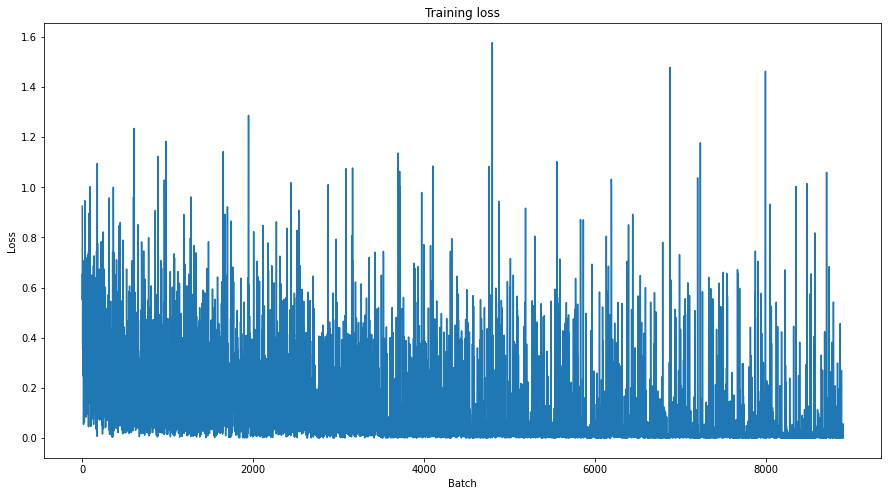

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

In [ ]:
import pandas as pd

df_test = pd.read_csv("./input/test_oJQbWVk.csv")

# Create sentence and label lists
sentences = df_test.tweet.values

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
#labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
#prediction_labels = torch.tensor(labels)
  
batch_size = 8  


#prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

model.load_state_dict(torch.load('./data/xlnet_model.bin'))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  #b_input_ids, b_input_mask, b_labels = batch
  b_input_ids, b_input_mask = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  #label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  #true_labels.append(label_ids)

In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [ ]:
sub = pd.DataFrame({'id':df_test['id'], 'label':flat_predictions})

# write predictions to a CSV file
sub.to_csv("sub_xlnet.csv", index=False)